In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd

# Experiment One

In [56]:
colors = "red purple blue green".split()
textures = "smooth spiky rough".split()
shapes = "sphere cube star".split()

class Fruit: # attributes: color, texture, shape
    def __init__(self, color, texture, shape, poison_func):
        assert color in colors, "Invalid color"
        assert texture in textures, "Invalid texture"
        assert shape in shapes, "Invalid shape"
        self.color = color
        self.texture = texture
        self.shape = shape
        self.poison_func = poison_func
    
    def __str__(self):
        return(f"{self.color} {self.texture} {self.shape}")
    def __repr__(self):
        return(f"{self.color} {self.texture} {self.shape}")
        
    
    def is_poisonous(self): # establish ground truth about fruit based on attributes. 
        # Here select that spiky fruits poisonous
        return(self.poison_func(self))
    
    def to_row(self):
        # convert to one hot encoding of fruit that can be added to dataframe as row
        return([colors.index(self.color), textures.index(self.texture), shapes.index(self.shape), int(self.is_poisonous())])
    
    @staticmethod
    def generate_random(poison_func): 
        color = colors[random.randint(0, len(colors)-1)]
        texture = textures[random.randint(0, len(textures)-1)]
        shape = shapes[random.randint(0, len(shapes)-1)]
        return(Fruit(color, texture, shape, poison_func))

In [82]:
def add_data(poison_func, n=10, df=None):
    if not df:
        df = pd.DataFrame(columns="colors textures shapes poisonous".split())
        df2 = pd.DataFrame(columns="colors textures shapes poisonous".split())
    for i in range(n):
        fruit = Fruit.generate_random(poison_func)
        df.loc[len(df.index)] = [colors.index(fruit.color), textures.index(fruit.texture), shapes.index(fruit.shape), int(fruit.is_poisonous())]
        df2.loc[len(df.index)] = [fruit.color, fruit.texture, fruit.shape, int(fruit.is_poisonous())]
    return(df)

In [83]:
add_data(is_poisonous)

,colors,textures,shapes,poisonous
0,0,1,1,0
1,2,1,0,1
2,2,1,0,1
3,1,1,2,0
4,0,0,1,0
5,3,0,2,0
6,2,1,1,0
7,0,0,1,0
8,2,2,0,1
9,3,2,1,0


In [84]:
def NaiveProbabilities(data, y, y_label='poisonous'):
    # posterior = prior * likelihood
    df = data[data[y_label]==y].drop([y_label], axis=1)
    count_y, num_features = df.shape
    prior = count_y / data.shape[0] # P(Y), prior
    max_length = max([len(eval(feature)) for feature in df.columns]) # 4
    probs = np.zeros((max_length, num_features))
    if(prior>0.0):
        # if there are fruits of desired class (at least one poisonous)
    
        for index in range(num_features):
            feature = df.columns[index]
            col = df[feature]
            for xj in range(max_length): # which feature value are we testing? P[Xi=xij | Y=y]; find range
                probs[xj, index] = col[col==xj].size / count_y
    
    return(pd.DataFrame(probs, columns=df.columns))

def Entropy(data, col_name):
    col = data[col_name]
    def H(p):
        if(p==0):
            return(0)
        return(-1 * p * np.log2(p))
    return(col.apply(H).sum())

In [85]:
def identify(fruit_data):
    prob_0 = NaiveProbabilities(data, y=0)
    prob_1 = NaiveProbabilities(data, y=1)
    
    entropies = {}
    for col in prob_0.columns:
        entropies[col] = [Entropy(prob_0, col)]
        entropies[col].append(Entropy(prob_1, col))
    var = ''
    lowest_entropy = 10000
    for col in prob_0.columns:
        #print(f"Testing {col}, champ {var}, with entropy {lowest_entropy}")
        if(sum(entropies[col]) < lowest_entropy):
            lowest_entropy = sum(entropies[col])
            var = col
    return(var, entropies)

In [86]:
colors = "red purple blue green".split()
textures = "smooth spiky rough".split()
shapes = "sphere cube star".split()

def is_poisonous(fruit): 
    return(fruit.texture == "spiky")
data = add_data(is_poisonous)
data

,colors,textures,shapes,poisonous
0,3,1,0,1
1,0,0,0,0
2,0,0,1,0
3,0,2,1,0
4,1,2,0,0
5,2,1,0,1
6,3,0,2,0
7,2,2,1,0
8,1,2,0,0
9,1,1,1,1


In [87]:
identify(data)

('textures',
 {'colors': [1.8423709931771088, 1.584962500721156],
  'textures': [0.9852281360342515, 0.0],
  'shapes': [1.4488156357251847, 0.9182958340544896]})

In [88]:
class CausalLink:
    def __init__(self, source, sink):
        # directed edge from v1 to v2, indicating one-way causality
        assert source != sink
        self.cause = source
        self.effect = sink
    def __repr__(self):
        return(f"{self.__class__}::{self.cause}-->{self.effect}")
    def __str__(self):
        return(f"{self.cause}-->{self.effect}")
    

class Feature:
    def __init__(self, name, data=0):
        self.parents = [] # edges where Feature is the effect
        self.children = []# edges where Feature is the cause
        self.data = data # is going to either be conditional prob or mutual information
        self.name = name

    def add_parent(self, node):
        if(node not in self.parents):
            self.parents.append(node)
    def add_child(self, node):
        if(node not in self.children):
            self.children.append(node)
    def in_degree(self):
        return(len(self.parents))
    def out_degree(self):
        return(len(self.children))
    
    def __repr__(self):
        return(f"{self.__class__}::{self.name}")
    def __str__(self):
        return(str(self.name))
    
    def __eq__(self, other):
        return (self.data, self.name) == (other.data, other.name)

In [89]:
class CausalGraph:
    def __init__(self):
        self.vertices = []
        self.edges = []
    
    def addNode(self, name):
        vertex = Feature(name)
        self.vertices.append(vertex)
    
    def addNodes(self, names):
        for name in names.split():
            self.addNode(name)
    
    def getNode(self, name):
        for vertex in self.vertices:
            if(vertex.name == name):
                return vertex
        return(None)
    
    def __str__(self):
        result = "["
        for v in self.vertices:
            result += str(v) + ", "
        result += "]\n"
        for edge in self.edges:
            result = result + str(edge) + "\n"
        return(result)
    
    def addEdge(self, name_1, name_2):
        source, sink = self.getNode(name_1), self.getNode(name_2)
        if(source and sink): # both exist as valid vertices
            edge = CausalLink(source, sink)
            self.edges.append(edge)

            source.add_child(sink)
            sink.add_parent(source)
        else:
            print("Invalid")
    
    

In [90]:
CausalGraph()

## Representation Structure 

In [91]:
class HierarchicalModel:
    def __init__(self, data, y_label='poisonous'):
        # first level of knowledge, the direct observed sample probabilities (corresponding to the "theta")
        self.LevelOne = { 
            0 : NaiveProbabilities(data, 0, y_label),
            1 : NaiveProbabilities(data, 1, y_label),
        }
        
        self.entropies = self.LearnCausalGraph()
    
    def LearnCausalGraph(self):
        # learn level two overhypothesis based on Naive Conditional Probabilities
        
        ## Naive way - with L3 overhypothesis of one feature being causally relevant
        prob_0 = self.LevelOne[0]
        prob_1 = self.LevelOne[1]
    
        entropies = {}
        for col in prob_0.columns:
            entropies[col] = [Entropy(prob_0, col)]
            entropies[col].append(Entropy(prob_1, col))
        cause = ''
        lowest_entropy = 100
        for col in prob_0.columns:
            #print(f"Testing {col}, champ {var}, with entropy {lowest_entropy}")
            if(sum(entropies[col]) < lowest_entropy): # find feature with lowest information entropy
                lowest_entropy = sum(entropies[col]) # adds up for both conditionals
                cause = str(col)
            elif(sum(entropies[col]) == lowest_entropy and cause!=''):
                # two variables have exact same information entropy
                cause += f" {col}"
                
        self.LevelTwo = CausalGraph()
        self.LevelTwo.addNodes("colors textures shapes poisonous")
        for c in cause.split():
            self.LevelTwo.addEdge(c, "poisonous")
        return(entropies)
    
    def hypothesis(self): # represents the overhypothesis model has learned
        # uses all levels of knowledge to posit what drives poisonous or not
        causes = [edge.cause.name for edge in self.LevelTwo.edges]
        cols = self.LevelOne[1][causes]
        indices = np.where(cols==1.0)
        if(len(indices[0])==1): # unambiguous - only one variable
            return([[causes[0], eval(causes[0])[indices[0][0]]]])
        if(len(indices[0])==0): # no poisonous fruit in data
            return([[causes[0], "unknown"]])
        if(len(indices[0])==2): # most sensible causal graph has two features
            return([[causes[0], eval(causes[0])[indices[0][0]]], [causes[1], eval(causes[1])[indices[0][1]]]])
    
    def is_poisonous(self, fruit):
        # using learned hierarchical model, guesses whether a given fruit is poisonous or not. 
        result = False
        for feature, value in self.hypothesis():
            result = eval(f"fruit.{feature[:-1]}") == value
        return(result)
            

In [92]:
eval(f"f2.shape") 

'sphere'

In [111]:
def is_poisonous(fruit): 
    return(fruit.shape == "sphere" or fruit.color=='purple')
data = add_data(is_poisonous)
HM = HierarchicalModel(data)

In [109]:
data

,colors,textures,shapes,poisonous
0,0,0,0,1
1,3,2,0,1
2,1,2,1,1
3,3,0,1,0
4,0,0,1,0
5,2,0,2,0
6,1,1,0,1
7,3,2,0,1
8,1,0,0,1
9,2,2,2,0


In [105]:
fruit = Fruit("purple", "smooth", "sphere", is_poisonous)

In [106]:
HM.is_poisonous(fruit)

False

In [107]:
print(HM.LevelTwo)
for a, b in HM.hypothesis():
    print(a,b)

[colors, textures, shapes, poisonous, ]
colors-->poisonous
shapes-->poisonous

colors unknown


In [102]:
data[data['poisonous']==1]

,colors,textures,shapes,poisonous
1,2,2,0,1
2,1,1,1,1
5,0,2,0,1
6,1,0,1,1
7,3,2,0,1


In [435]:
def evaluate_model(feature, value, n):
    def poison_func(fruit): 
        return(eval(f"fruit.{feature[:-1]}") == value)
    data = add_data(poison_func, n)
    try:
        HM = HierarchicalModel(data)
        feature_guess, value_guess = HM.hypothesis().split()
        match = feature == feature_guess and value==value_guess
        return(match, (data,HM))
    except Exception:
        print("some error occurred")
        return(False, data, Exception)

In [28]:
for i,j in [[0,4]]:
    print(j)


4


In [458]:
def getAccuracies():
    colors = "red purple blue green".split()
    textures = "smooth spiky rough".split()
    shapes = "sphere cube star".split()
    num_trials = 100
    
    num_fruits = [1,3,5,6,8,10,15,20,30] # number of samples to try
    accuracies = [] # accuracy dependent on num_fruits seen
    
    for n in num_fruits:
        counter = 0.0
        for trial in range(num_trials): # average accuracy over multiple trials
            feature = random.choice("colors textures shapes".split()) # choose causal feature
            value = random.choice(eval(feature)) # choose which value makes a fruit poisonous
            def poison_func(fruit): 
                return(eval(f"fruit.{feature[:-1]}") == value)
            data = add_data(poison_func, n)
            try:
                HM = HierarchicalModel(data)
                feature_guess, value_guess = HM.hypothesis().split(",")[0].split()
                match = feature == feature_guess and value==value_guess
                counter += int(match)
            except:
                pass
        accuracies.append(counter / num_trials)
    return(num_fruits, accuracies) 

In [459]:
x2, y2 = getAccuracies()

In [452]:
list(zip(x,y))

[(1, 0.0),
 (3, 0.3),
 (5, 0.43),
 (6, 0.63),
 (8, 0.8),
 (10, 0.9),
 (15, 0.98),
 (20, 0.98),
 (30, 0.99),
 (40, 1.0)]

In [112]:
textures

['smooth', 'spiky', 'rough']

In [460]:
list(zip(x2,y2))

[(1, 0.0),
 (3, 0.28),
 (5, 0.57),
 (6, 0.65),
 (8, 0.87),
 (10, 0.9),
 (15, 0.94),
 (20, 0.97),
 (30, 1.0)]

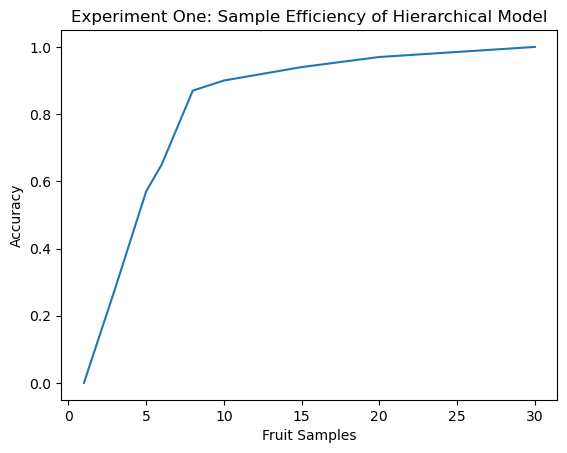

In [463]:
plt.plot(x2, y2)
plt.xlabel("Fruit Samples")
plt.ylabel("Accuracy")
plt.title("Experiment One: Sample Efficiency of Hierarchical Model")
plt.savefig("Experiment One")

In [241]:
plt.plot()

(False,
 (   colors  textures  shapes  poisonous
  0       1         1       2          0
  1       1         0       2          0
  2       3         2       2          0
  3       2         0       0          0
  4       0         0       2          1
  5       0         2       2          1
  6       3         2       2          0
  7       1         1       0          0
  8       1         1       2          0
  9       0         2       2          1,
  <__main__.HierarchicalModel at 0x7fcd6361dab0>))

In [391]:
data, info = evaluate_model('colors', 'red', 10)
data

some error occurred


,colors,textures,shapes,poisonous
0,0,1,1,1
1,3,0,2,0
2,0,1,0,1
3,0,1,2,1
4,3,2,0,0
5,2,1,0,0
6,3,1,2,0
7,1,1,1,0
8,2,2,0,0
9,2,2,1,0


In [386]:
info

(   colors  textures  shapes  poisonous
 0       3         2       0          0
 1       1         1       0          0
 2       0         0       0          1
 3       2         0       2          0
 4       3         0       1          0
 5       0         0       0          1
 6       3         1       2          0
 7       0         0       2          1
 8       2         0       1          0
 9       2         0       0          0,
 <__main__.HierarchicalModel at 0x7fcd6370f370>)

In [392]:
HM = HierarchicalModel(data)
HM.LevelTwo.edges

[<class '__main__.CausalLink'>::colors-->poisonous,
 <class '__main__.CausalLink'>::textures-->poisonous]

In [404]:
HM.hypothesis()

In [393]:
HM.entropies

{'colors': [1.4488156357251847, 0.0],
 'textures': [1.4488156357251847, 0.0],
 'shapes': [1.5566567074628228, 1.584962500721156]}

In [405]:
causes = [edge.cause.name for edge in HM.LevelTwo.edges]
cols = HM.LevelOne[1][causes]
indices = np.where(cols==1.0)
if(len(indices[0])==1):
    print(f"{causes[0]} {eval(causes[0])[indices[0][0]]}")

In [397]:
indices

(array([0, 1]), array([0, 1]))

In [408]:
data

,colors,textures,shapes,poisonous
0,0,1,1,1
1,3,0,2,0
2,0,1,0,1
3,0,1,2,1
4,3,2,0,0
5,2,1,0,0
6,3,1,2,0
7,1,1,1,0
8,2,2,0,0
9,2,2,1,0


In [409]:
indices

(array([0, 1]), array([0, 1]))

In [406]:
HM.LevelOne[1][causes]

,colors,textures
0,1.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0


In [368]:
causes

['colors']

In [328]:
HM.LevelOne[0][['colors', 'textures']]

,colors,textures
0,0.0,0.3
1,0.2,0.3
2,0.8,0.4
3,0.0,0.0


In [331]:
np.where(HM.LevelOne[0][['colors', 'textures']]==0.3)

(array([0, 1]), array([1, 1]))

In [248]:
HM.hypothesis()

'shapes cube'

In [237]:
a[1][1].LevelOne

{0:      colors  textures    shapes
 0  0.000000  0.333333  0.111111
 1  0.333333  0.333333  0.777778
 2  0.333333  0.333333  0.111111
 3  0.333333  0.000000  0.000000,
 1:    colors  textures  shapes
 0     1.0       1.0     1.0
 1     0.0       0.0     0.0
 2     0.0       0.0     0.0
 3     0.0       0.0     0.0}

### Comparison to Gopnik

In [52]:
def poison_func(fruit):
    return(fruit.shape == 'star')
HM = HierarchicalModel(add_data(poison_func))

f1 = Fruit("purple", "smooth", "sphere", poison_func)
f2 = Fruit("red", "rough", "sphere", poison_func)
f3 = Fruit("blue", "rough", "star", poison_func)
def add_data_from_fruits(fruits):
    df = pd.DataFrame(columns="colors textures shapes poisonous".split())
    for fruit in fruits:
        df.loc[len(df.index)] = [colors.index(fruit.color), textures.index(fruit.texture), shapes.index(fruit.shape), int(fruit.is_poisonous())]
    return(df)
add_data_from_fruits([f1,f2,f3])

,colors,textures,shapes,poisonous
0,1,0,0,0
1,0,2,0,0
2,2,2,2,1


In [53]:
HM = HierarchicalModel(add_data_from_fruits([f1,f2,f3]))
HM.hypothesis()

[['shapes', 'star']]

In [49]:
HM.is_poisonous(f3)

True

In [224]:
a

,colors,textures,shapes,poisonous
0,2,1,2,0
1,3,0,0,0
2,2,1,2,0
3,0,1,1,1
4,0,2,0,1
5,0,0,1,1
6,0,0,2,1
7,0,0,1,1
8,1,1,1,0
9,0,2,0,1


In [212]:
b

(   colors  textures  shapes  poisonous
 0       2         1       1          0
 1       0         2       1          1
 2       1         2       1          0
 3       3         0       0          0
 4       0         0       2          1
 5       0         2       1          1
 6       1         2       2          0
 7       2         2       1          0
 8       1         0       2          0
 9       3         0       2          0,
 <__main__.HierarchicalModel at 0x7fcd50593d90>)

In [192]:
b[1].LevelOne

{0:      colors  textures    shapes
 0  0.000000  0.444444  0.222222
 1  0.222222  0.111111  0.444444
 2  0.333333  0.444444  0.333333
 3  0.444444  0.000000  0.000000,
 1:    colors  textures  shapes
 0     1.0       1.0     0.0
 1     0.0       0.0     1.0
 2     0.0       0.0     0.0
 3     0.0       0.0     0.0}

In [194]:
b[1].entropies

{'colors': [1.5304930567574826, 0.0],
 'textures': [1.3921472236645345, 0.0],
 'shapes': [1.5304930567574826, 0.0]}